In [1]:
from treeVisuals import *

In [2]:
root = make(range(7))
visual(root)

------------------------
              0  
      1               2  
  3       4       5       6  
________________________


['1', 'N', '7', '6', '10', '2', 'N', '9', 'N', 'N', '3', '8', 'N', 'N', '5', 'N', 'N', '4', '3', '5', '7']


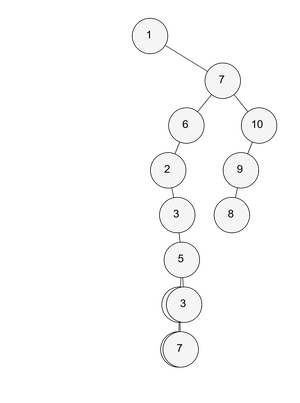

In [26]:
from PIL import ImageFont
from PIL import Image, ImageDraw, ImageFont
from collections import defaultdict, deque
from math import log2, ceil, log10

class DrawTree:
    def __init__(self, root, size=None):        
        self.root = root
        
        # width, height
        self.bg_size = (5000, 3000)
        if size:
            factor = size[0]/self.bg_size[0]
            self.resize = (self.bg_size[0] * factor, self.bg_size[1]*factor)
        else:
            self.resize = (500, 300)
            
        self.node_size = (600, 600)
        self.font_size = 180
        self.line_width = 10
        
        self.clrs = {
                     'white': (245, 245, 245), 
                     'blue': (191, 213, 255), 
                     'green': (191, 255, 192), 
                     'red': (255, 191, 191), 
                     'cyan': (184, 255, 251),
                     'black': (20, 20, 20),
                    }
        self.bg_clr = (255, 255, 255, 50)
        self.node_clr = 'white'
        self.font_clr = 'black'
        self.outline_clr = 'black'
        
        self.height = 0
        self.node_map = defaultdict(lambda :None)
        self.max_chrs = 6
        self.factor = 10**(log10(self.bg_size[0]/self.resize[0]))
    
    def drawPoint(self, pos):
        self.draw.ellipse(tuple(map(int, (pos[0]-10, pos[1]-10, pos[0]+10, pos[1]+10))), fill=self.clrs['black'], outline=self.outline_clr, width=self.line_width)
        
    def drawNode(self, root, pos):
        if root is None: return 
        x1, y1 = pos[0] - self.node_size[0]/2, pos[1] - self.node_size[1]/2
        x2, y2 = pos[0] + self.node_size[0]/2, pos[1] + self.node_size[1]/2
        
        posf = ((pos[0] + x1)/2, (pos[1] + y1)/2)
        self.draw.ellipse(tuple(map(int, (x1, y1, x2, y2))), fill=self.clrs[self.node_clr], outline=self.outline_clr, width=self.line_width)
        self.drawFont(tuple(map(int, pos)), root.val)
    
    def drawLine(self, point1, point2):
        self.draw.line(tuple(map(int, (*point1, *point2))), fill=self.clrs[self.outline_clr], width=self.line_width)
    
    def drawFont(self, pos, string):
        string = str(string)
        if len(string) > 6: string = string[:4] + '..'
        font = ImageFont.truetype("arial", self.font_size)
        W, H = pos
        w, h = self.draw.textsize(string)
        v = 0.32 if self.font_size == 100 else 0.67
        self.draw.text(tuple(map(int, (W - w*self.factor*v, H - h*self.factor*v))), string, fill=self.font_clr, font=font)
    
    def drawTree(self, color='white'):
        self.node_clr = color if color in self.clrs else 'white'
        self.height, right, left = self.getDimension()
        bg_width = max(self.bg_size[0], self.node_size[1]*1.4*(right - left + 1))
        bg_height = max(self.bg_size[1], self.node_size[0]*1.4*self.height)
        
        self.bg_size = (int(bg_width), int(bg_height))
        self.resize = (int(bg_width/self.factor), int(bg_height/self.factor))
        self.image = Image.new('RGBA', self.bg_size, self.bg_clr)
        self.draw = ImageDraw.Draw(self.image)
        
        q = deque([(self.root, 1)])
        
        # fill node_map
        max_chr = 0
        while q:
            node, l = q.popleft()
            if node:
                self.node_map[l] = node
                q.append((node.left, 2*l))
                q.append((node.right, 2*l + 1))
                
                max_chr = max(max_chr, len(str(node.val)))
                
        if max_chr >= 3:
            self.font_size = 100
          
        # draw edges
        for i in self.node_map:
            node = self.node_map[i]
            if node:
                if (2*i) in self.node_map: 
                    self.drawLine(self.getPosOnSheet(i),self.getPosOnSheet(2*i))
                
                if (2*i + 1) in self.node_map:
                    self.drawLine(self.getPosOnSheet(i),self.getPosOnSheet(2*i + 1))
        
        # draw nodes
        for i in self.node_map:
            node = self.node_map[i]
            if node:
                self.drawNode(node, self.getPosOnSheet(i))

        self.image = self.image.resize(self.resize, resample=Image.ANTIALIAS)
        self.image.save('tree.png')
        return self.image
    
    def getPos(self, i):
        return (i - 2**(ceil(log2(i+1))-1), ceil(log2(i+1))-1)
    
    def getPosOnSheet(self, i):
        w, h = self.getPos(i)
        
        bg_width, bg_height = self.bg_size
        space_x = self.node_size[0]/2
        space_y = self.node_size[1]/2
        
        posx = space_x/4 + (w/2**h)*(bg_width - 0.5*space_x) + ((bg_width - 0.5*space_x) - ((2**h - 1)/2**h)*(bg_width - 0.5*space_x))/2
        posy = space_y*2 + (h/(self.height+1))*(bg_height)
        
        return (posx, posy)
        
    def getDimension(self):
        root = self.root
        
        def dfs(root, h=0, l=0, r=0):
            if root is None: return h, l, r
            h1, r1, l1 = dfs(root.left, h+1, l+1, r-1)
            h2, r2, l2 = dfs(root.right, h+1, l-1, r+1)
            return max(h1, h2), max(r1, r2), min(l1, l2)
        
        return dfs(self.root)
        
lis = "1 N 7 6 10 2 N 9 N N 3 8 N N 5 N N 4 3 5 7".split()
print(lis)
root = makeLevel(lis)
DrawTree(root, (300, 300)).drawTree()

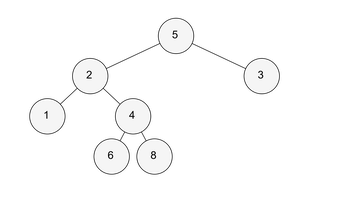

In [24]:
root = make([5, 2, 3, 1, 4, 'N', 'N', 'N', 'N', 6, 8])
DrawTree(root, (300, 300)).drawTree()

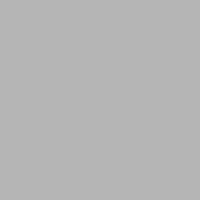

In [4]:
# set background
from PIL import *
from PIL import ImageFont

size = (200, 200)
color = (180, 180, 180)
image = Image.new('RGBA', size, color)
image

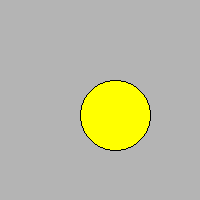

In [5]:
# draw elipse 
x1, y1, x2, y2 = 80, 80, 150, 150
coords = (x1, y1, x2, y2)
draw = ImageDraw.Draw(image)
draw.ellipse(coords, fill='yellow', outline='black')
image

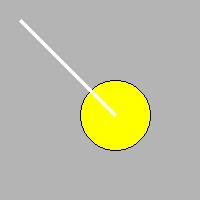

In [6]:
# draw line
point1, point2 = (20, 20), (115, 115)
draw.line((*point1, *point2), fill='white', width=3)
image

In [7]:
print(list(range(127)))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126]
